# 01. Modeling & Simulation

In [1]:
# imports
import sys
sys.path.append('..')
from estim8.models import FmuModel
from estim8.visualization import plot_simulation

## 1.1 Mathematical model formulation
We demonstrate the workflow along an example of a simple batch cultivation. Here, exponential growth of a microbial culture, respesented as biomass concentration $X  \; [g \cdot L^{-1}]$, can be modeled by the *Ordinary Differential Equation* (DAE)

$$
\begin{align}
    \frac{d}{dt} X(t) &= \mu(t) \cdot X(t) \quad , \quad X(t=0)=X_{t0}
    
\end{align}
$$

where $X_{t0}$ describes the initial biomass concentration  and $\mu(t) \; [h^{-1}]$ the specific growth rate. The latter can be calculated following *Michaelis Menten* kinetics via

$$
\begin{align}
    \mu(t) &= \mu_{max} \cdot \frac{S(t)}{S(t)+K_S}
\end{align}
$$

where $\mu_{max} \; [h^{-1}]$ denotes the strain and substrate specific maximum growth rate, $S(t) \; [g \cdot L^{-1}]$ the substrate concentration at time $t$. The depletion of $S$ due to microbial consumption is defined by

$$
\begin{align}
    \frac{d}{dt} S(t) &= -\mu(t) \cdot \ X(t) \cdot \frac{1}{Y_{X_S}} \quad , \quad S(t=0)=S_{t0}
\end{align}
$$

Here $Y_{X_S} [\frac{g_X}{g_S}]$ denotes the biomass specific yield coefficient.

## 1.2 Model implementation
Next, we implement the model using the modeling language [Modelica](https://modelica.org/) as shown below. [OpenModelica](https://openmodelica.org/) offers an open-source and interactive environment for this purpose. 

```modelica
model SimpleBatch
  
  // define real states
  Real X(start = X0, fixed = true);
  Real S(start = S0, fixed = true);
  Real mu;

  // define variables
  parameter Real X0 = 0.1;
  parameter Real S0 = 10;
  parameter Real mu_max = 0.5;
  parameter Real Ks = 0.01;
  parameter Real Y_XS = 0.5;

equation
  der(X) = mu*X;
  der(S) = -mu*X/Y_XS;
  mu = mu_max*S/(Ks + S);

// prevent negative states
if (S<=0) then
  S=0;
 end if;
 

end SimpleBatch;
```

To use this model with `estim8` , we export it as a _Functional Mockup Unit_ (FMU). Supported are both FMI types _Co-Simulation_ and _Model-Exchange_ .

## 1.3 Modeling & Simulation with `estim8.FmuModel`

The `FmuModel` class offers a Python simulation interface for FMUs. For initialization, we simply pass the FMU's filepath. Additional keyword arguments are:

| Kwarg | type | description |
| ----- |----- |------------ |
| fmi_type | str | The FMI type used for Simulation. Supported are "ModelExchange"(default) and "CoSimulation". |
| default_parameters | dict | A dictionary in form {"param": val} to define default parameters. |
| r_tol | float | Relative tolerance for the 'CVode' solver and co-simulation of FMUs, default is $1e^{-4}$.|

In [2]:
SimpleBatchModel = FmuModel('SimpleBatch.fmu')


### 1.3.1 Managing model properties

#### Model parameters 
The models `parameters` are accessible in form of a dictionary via the class property. To change model parameters, simply redefine the values of parameter keys.


In [3]:
print('Parameters before: \n', SimpleBatchModel.parameters)
# change a single parameter, e.g. mu_max 
SimpleBatchModel.parameters['mu_max'] = 0.4
print("\nParameters after changing:\n", SimpleBatchModel.parameters)

Parameters before: 
 {'Ks': 0.01, 'S0': 10.0, 'X0': 0.1, 'Y_XS': 0.5, 'mu_max': 0.5}

Parameters after changing:
 {'Ks': 0.01, 'S0': 10.0, 'X0': 0.1, 'Y_XS': 0.5, 'mu_max': 0.4}


#### Simulation flags
Both 'fmi_type' and 'r_tol' can be changed using the property setter methods:

In [4]:
print(f'Before:\n FMI type: {SimpleBatchModel.fmi_type},  r_tol={SimpleBatchModel.r_tol}')
# change both values
SimpleBatchModel.fmi_type = 'CoSimulation'
SimpleBatchModel.r_tol = 1e-4

print(f'After:\n FMI type: {SimpleBatchModel.fmi_type},  r_tol={SimpleBatchModel.r_tol}')


Before:
 FMI type: ModelExchange,  r_tol=0.0001
After:
 FMI type: CoSimulation,  r_tol=0.0001


### 1.3.2 Simulation

The model can be simulated using the class method `simulate`, which at least requires the following arguments:

| arg  | type  |  description |
| ----  | ----  |     ----     |
| t0    | float | Start time of the simulation  |
| t_end | float | End time of the simulation    |
| stepsize | float | Stepsize of the DAE solver |

Additional keyword arguments comprise:

| kwarg  | type  |  description |
| ----  | ----  |     ----     |
| parameters | dict[float] | Parameters to use for simulation, if not specified the values class property `parameters`are used. |
| observe | list[str] | Quantitites to observe, default is None which means all observable quantities within the model |
| r_tol   | float | Relative solver tolerance, default is None which means the class property `r_tol` as shown above is ujsed|
| solver | string | Solver to use in ModelExchange, default is Cvode |
| replicate_ID | str | Replicate ID, default is None |

The method returns a `Simulation` object, which contains a list of `ModelPredictions`.

In [5]:
# simulation using default values and settings
simulation = SimpleBatchModel.simulate(
    t0= 0,
    t_end= 10,
    stepsize=0.1,
    )

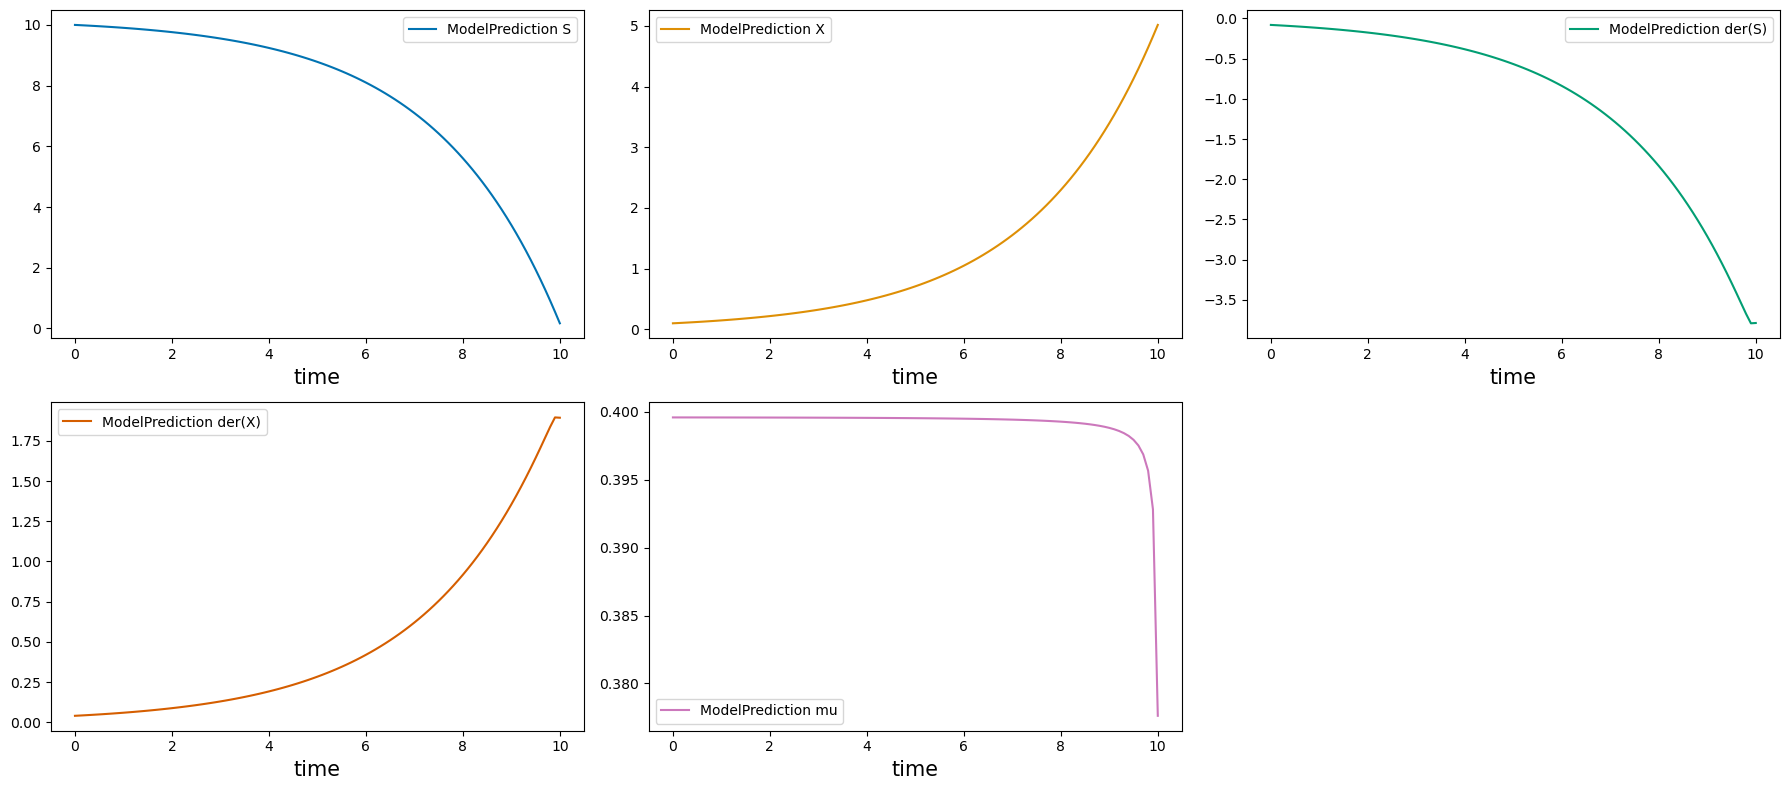

In [6]:
_ = plot_simulation(simulation=simulation, observe=None)